In [183]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.datasets import make_sparse_spd_matrix

In [231]:
def fill_triangular(L, D_in):
    lower_indices = np.tril_indices(D_in)
    l_matrix = np.zeros((D_in, D_in), dtype=L.dtype)
    l_matrix[lower_indices] = L
    return l_matrix

def malhanobis_dist(X, X2=None, precision=None):
    if X2 is None:
        X2 = X
    XP = np.matmul(np.expand_dims(X, 1), precision)
    X2P = np.matmul(np.expand_dims(X2, 1), precision)
    X11 = np.squeeze(np.matmul(XP, np.expand_dims(X, -1)), -1)
    X22 = np.squeeze(np.matmul(X2P, np.expand_dims(X2, -1)), -1).T
    X12 = np.matmul(np.matmul(X, precision), X2.T)

    dist = X11 - 2*X12 + X22

    return dist

def random_offdiag_precision(D, random_offdiag='no', n_offdiag=1, norm=True):
    diag = np.ones(D)
    L = np.diag(diag, 0)
    if n_offdiag > D-1:
        n_offdiag = D-1
    for n in range(n_offdiag):
        i = n+1
        # define the offdiagonal
        if random_offdiag == 'no':
            offdiag = D**0.5 * np.ones(D-i)
        elif random_offdiag == 'uniform':
            offdiag = np.random.uniform(0, 1, D-i)
        elif random_offdiag == 'gaussian':
            offdiag = np.random.normal(-1, 1, D-i)
        # add it to the matrix L
        L += np.diag(offdiag, -i)
    # define the precision matrix
    precision = L @ L.T
    if norm:
        # normalize the precision matrix to have ones on the diagonal
        diag_m = np.diag(1/np.diag(precision))
        precision = (np.sqrt(diag_m) @ precision) @ np.sqrt(diag_m)
    return precision

def generate_precision_sparse_random(D, data_rvs):
  # Generate a matrix that will become lower triangular
  L = scipy.sparse.random(D,D,density=0.5,data_rvs=data_rvs.rvs).A
  # Set upper elements to 0 and assure positive diagonal elements
  for i in range(D):
    for j in range(D):
      if i < j:
        L[i,j] = 0
      elif i == j:
        L[i,j] = np.abs(L[i,j])
  # Construct a symmetric matrix
  P = L + L.T
  return L @ L.T #P @ P.T

def sparse_psd(D, alpha=0.95, norm=True):
    return make_sparse_spd_matrix(dim=8, norm_diag=norm, alpha=0.7)


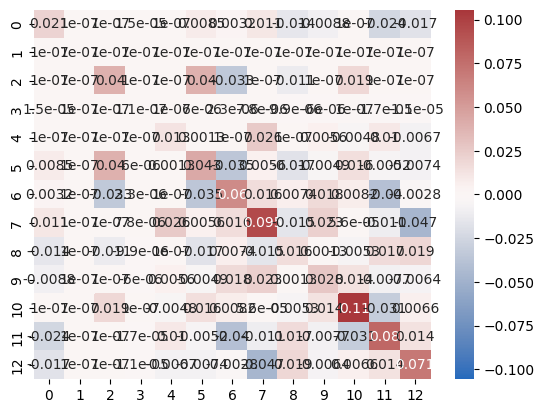

In [302]:
D = 13
#precision = random_offdiag_precision(D, random_offdiag='gaussian', n_offdiag=1, norm=True)
#precision = sparse_psd(D, norm=False, alpha=0.5)
#precision = np.load('./simulated/sparse_precision_D13_1.npy')
#precision = (precision - np.mean(precision, axis=0))/np.std(precision, axis=0)
precision = generate_precision_sparse_random(D, scipy.stats.laplace(loc=0,scale=.1)) + 1e-7
sns.heatmap(precision, cmap='vlag', annot=True, vmax=np.max(precision), center=0, vmin=-np.max(precision))

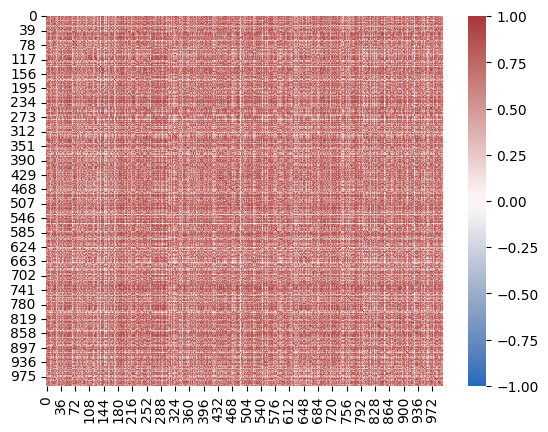

In [304]:
N = 1000
kernel_variance = 1
noise_variance = 0.1
X = np.random.multivariate_normal(np.zeros(D), np.eye(D), size=N)
#X = (X - np.mean(X, axis=0)) / (np.std(X, axis=0)+1e-9)
K = kernel_variance * np.exp(-0.5 * malhanobis_dist(X, precision=precision))
noise = np.random.normal(0, noise_variance, size=N)
Y = (np.random.multivariate_normal(np.zeros(N), K, size=1) + noise).reshape(-1,1)
sns.heatmap(K, cmap='vlag', annot=False, vmax=np.max(K), center=0, vmin=-np.max(K))

In [305]:
df = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(1, X.shape[1] + 1)])
df['label'] = Y

# Save DataFrame to CSV
df.to_csv(f'./simulated/scipy-d{D}-5.csv', index=False)
np.savez(f'./simulated/scipy-d{D}-5', precision=precision, kernel_variance=kernel_variance, noise_variance=noise_variance, D=D, N=N)

In [308]:
kernel_data = np.load(f'../results/run-0024/kernel/kernel_samples.npz')
D = kernel_data['D']
num_samples = kernel_data['kern.L'].shape[0]
precision_samples = np.empty((num_samples, D, D)) # S x D x D
for s in  range(num_samples):
    L =  fill_triangular(kernel_data['kern.L'][s], D) 
    precision = L @ L.T
    precision_samples[s] = precision
precision_mean = np.mean(precision_samples, axis=0) # D x D
precision_std = np.std(precision_samples, axis=0) # D x D
L = np.linalg.cholesky(precision_mean)

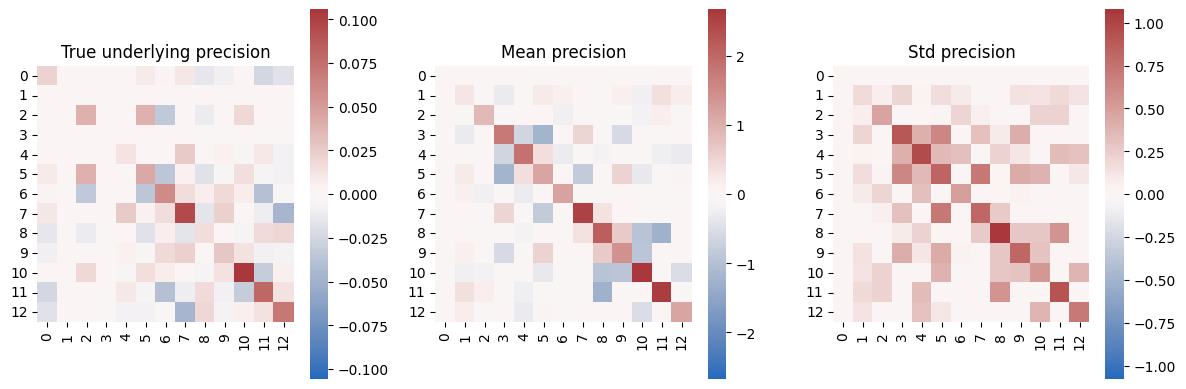

In [309]:
sim_data_res = np.load(f'./simulated/scipy-d{D}-5.npz')
true_precision = sim_data_res['precision']
fig, axs = plt.subplots(1,3,figsize=(12,4))
sns.heatmap(precision_mean, cmap='vlag', vmin=-np.max(precision_mean), center=0, vmax=np.max(precision_mean), annot=False, square=True, cbar=True, ax=axs[1])
sns.heatmap(precision_std, cmap='vlag', vmin=-np.max(precision_std), center=0, vmax=np.max(precision_std), annot=False, square=True, cbar=True, ax=axs[2])
sns.heatmap(true_precision, cmap='vlag', vmin=-np.max(true_precision), center=0, vmax=np.max(true_precision), annot=False, square=True, cbar=True, ax=axs[0])
axs[0].set_title('True underlying precision')
axs[1].set_title('Mean precision')
axs[2].set_title('Std precision')
plt.tight_layout()
plt.show()